In [34]:
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [39]:
base_dir = "./ranzcr_clip_catheter_line_classification/"

train_df = pd.read_csv(os.path.join(base_dir, "train.csv"))
train_df.nunique()
train_df.head()
#3255 unique patients, We want to make sure that each patient's images do not appear in multiple folds to avoid data leakage

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [40]:
#some patients have over 100 images and some have only 1
train_df.PatientID.value_counts()

05029c63a    172
55073fece    167
26da0d5ad    148
8849382d0    130
34242119f    110
            ... 
043effdf5      1
7283d5e8f      1
012ea1a54      1
780815d12      1
a646e1291      1
Name: PatientID, Length: 3255, dtype: int64

                  Malpositions  Number of Observations
0               ETT - Abnormal                      79
1             ETT - Borderline                    1138
2                 ETT - Normal                    7240
3               NGT - Abnormal                     279
4             NGT - Borderline                     529
5    NGT - Incompletely Imaged                    2748
6                 NGT - Normal                    4797
7               CVC - Abnormal                    3195
8             CVC - Borderline                    8460
9                 CVC - Normal                   21324
10  Swan Ganz Catheter Present                     830


<BarContainer object of 11 artists>

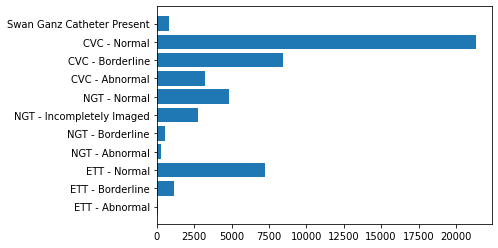

In [41]:
#plot label distrobution
categories = ['ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal','Swan Ganz Catheter Present']
categoryCounts = train_df[categories].sum(axis = 0).reset_index()
categoryCounts.columns = ['Malpositions', 'Number of Observations']
print(categoryCounts)
plt.barh(categoryCounts['Malpositions'], categoryCounts['Number of Observations'])


In [42]:
#concat all the labels into a single number
target_cols = train_df.drop(['StudyInstanceUID', 'PatientID'],axis=1).columns.values.tolist()
targets = train_df[target_cols].astype(str)
# create a new col to store the label
train_df['combined_label'] = ''
for i in range(targets.shape[1]):
    train_df['combined_label'] += targets.iloc[:,i]
# how many of each label there are
train_df.combined_label.value_counts()
#encode training labels
train_df['combined_label'] = LabelEncoder().fit_transform(train_df['combined_label'])


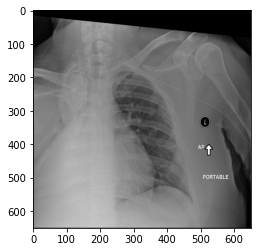

In [46]:
def load_resize_training_data(imageSize=650, numImages = 1000):
    path = os.path.join(base_dir, "train/")
    trainingData = []
    i=0
    for img in os.listdir(path):
        if i==numImages:
            break
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resized_array = cv2.resize(img_array, (imageSize, imageSize))
        trainingData.append([resized_array, train_df.loc[[i], ['combined_label']]])
        i+=1

    plt.imshow(trainingData[0][0], cmap="gray")

    return trainingData

data = load_training_data()

In [ ]:
# build a sequential model
model = Sequential()
model.add(InputLayer(input_shape=(224, 224, 3)))

# 1st conv block
model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())
# 3rd conv block
model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())
# ANN block
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.25))
# output layer
model.add(Dense(units=10, activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# fit on data for 30 epochs
model.fit_generator(train, epochs=30, validation_data=val)
